In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import torch
torch.manual_seed(0)

import tensorflow as tf
from neural_circuits.LRRNN import get_W_eigs_np, get_W_eigs_tf, get_simulator, \
                                  get_epi_times, get_snpe_times, \
                                  load_ME_EPI_LRRNN, load_best_SNPE_LRRNN, \
                                  SNPE_entropy,\
                                  tf_num_params, torch_num_params, eig_scatter

import warnings
warnings.filterwarnings('ignore')

"""RNN stable amplification."""

'RNN stable amplification.'

## Supp Fig 1

In [2]:
# SNPE setup

K = 1
num_sims = 1000
num_batch = 200
num_atoms = 100
x0 = np.array([0.5, 1.5])

# EPI setup
J_eig_realmax_mean = 0.5
Js_eig_max_mean = 1.5
eig_std = 0.25
mu = np.array([J_eig_realmax_mean,
               Js_eig_max_mean,
               eig_std**2,
               eig_std**2], dtype=np.float32)

Ns = [2, 10]
gs = [0.01, 0.1]
num_Ns = len(Ns)
num_gs = len(gs)
random_seeds = [1,2,3,4,5]

SNPE_max_val = {}
EPI_max_ent = {}
for i, N in enumerate(Ns):
    for j, g in enumerate(gs):
        snpe_optim = load_best_SNPE_LRRNN(N, g, K, x0,
                                          num_sims=num_sims, 
                                          num_batch=num_batch, 
                                          num_atoms=num_atoms,
                                          random_seeds=random_seeds)
        SNPE_max_val.update({(N,g):snpe_optim})

        epi_optim = load_ME_EPI_LRRNN(N, g, K, mu, by_df=True)
        EPI_max_ent.update({(N,g):epi_optim})

Processing SNPE N=2, g =0.01, rs=5.
Processing EPI: D=8, rs=1.
Processing EPI: D=8, rs=3.
Processing EPI: D=8, rs=4.
Processing EPI: D=8, rs=5.
Processing EPI: D=8, rs=2.

Processing SNPE N=2, g =0.10, rs=5.
Processing EPI: D=8, rs=3.
Processing EPI: D=8, rs=2.

Processing SNPE N=10, g =0.01, rs=5.
Processing EPI: D=40, rs=5.
Processing EPI: D=40, rs=2.
Processing EPI: D=40, rs=3.
Processing EPI: D=40, rs=4.
Processing EPI: D=40, rs=1.

Processing SNPE N=10, g =0.10, rs=5.
Processing EPI: D=40, rs=2.
Processing EPI: D=40, rs=3.
Processing EPI: D=40, rs=1.



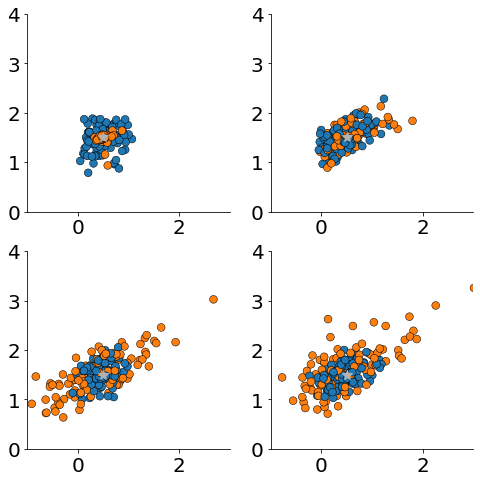

In [4]:
colors = sns.color_palette()
num_plot = 100
figlen = 4
fig, axs = plt.subplots(num_Ns, num_gs, figsize=(num_gs*figlen,num_Ns*figlen))
for i, N in enumerate(Ns):
    for j, g in enumerate(gs):
        ax = axs[i][j]
        # plot EPI
        optim = EPI_max_ent[(N,g)]
        dist, model = optim['dist'], optim['model']
        epi_z = dist(num_plot)
        epi_T_x = model.eps(epi_z).numpy()[:,:2]
        
        # plot SNPE
        optim = SNPE_max_val[(N, g)]
        best_round = np.argmax(optim['round_val_log_probs'])+1
        snpe_T_x = optim['xs'][best_round][:num_plot]
        perm = not (i==0 and j==0)
        eig_scatter([epi_T_x, snpe_T_x], colors=colors, ax=ax, perm=perm)
        ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig(os.path.join("figures", "figRNN1", "RNN1_scatters.pdf"))

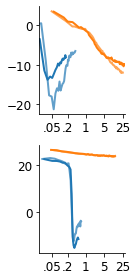

In [6]:
colors = sns.color_palette()
num_plot = 200
figlen = 4
alphas = [0.7, 1.]
xticklabels = [".05", ".2", "1","5", "25"]
_xticklabels = [.05, .2, 1, 5, 25]
xticks = np.log(np.array(_xticklabels))
min_time = 1./60.
max_time = None

fig, axs = plt.subplots(num_Ns, 1, figsize=(figlen/2.,figlen))
for i, N in enumerate(Ns):
    ax = axs[i]
    for j, g in enumerate(gs):
        # plot EPI
        optim = EPI_max_ent[(N,g)]
        epi_H = optim['H']
        epi_t = get_epi_times(optim)
        ax.plot(np.log(epi_t/60.), epi_H, c=colors[0], alpha=alphas[j])
        
        # plot SNPE
        optim = SNPE_max_val[(N, g)]
        best_round = np.argmax(optim['round_val_log_probs'])+1
        log_probs = optim['log_probs'][:best_round]
        epoch_times, round_times = get_snpe_times(optim)
        snpe_t = round_times[:best_round]
        snpe_H = SNPE_entropy(log_probs)
        ax.plot(np.log(snpe_t/60.), snpe_H, c=colors[1], alpha=alphas[j])
        if max_time is None or np.max(snpe_t/60.) > max_time:
            max_time = np.max(snpe_t) / 60.
for i, N in enumerate(Ns):
    axs[i].set_xlim([np.log(min_time), np.log(max_time)])
    axs[i].set_xticks(xticks)
    axs[i].set_xticklabels(xticklabels)
plt.tight_layout()
plt.savefig(os.path.join("figures", "figRNN1",  "RNN1_H.pdf"))

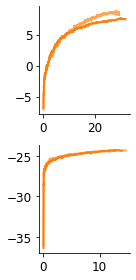

In [7]:
fig, axs = plt.subplots(num_Ns, 1, figsize=(figlen/2.,figlen))
for i, N in enumerate(Ns):
    ax = axs[i]
    for j, g in enumerate(gs):
        optim = SNPE_max_val[(N, g)]
        val_log_probs = optim['summary']['validation_log_probs']
        epoch_times, round_times = get_snpe_times(optim) 
        snpe_t = epoch_times[1:]
        ax.plot(snpe_t/60., val_log_probs, c=colors[1], alpha=alphas[j])
    #ax.set_xlim([np.log(min_time), np.log(max_time)])
plt.tight_layout()
plt.savefig(os.path.join("figures", "figRNN1", "RNN1_log_probs.pdf"))

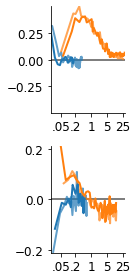

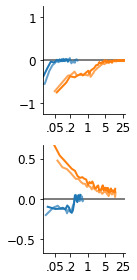

In [8]:
for k in range(2):
    fig, axs = plt.subplots(num_Ns, 1, figsize=(figlen/2.,figlen))
    for i, N in enumerate(Ns):
        ax = axs[i]
        ax.plot([-100, 100], [0,0], '-k', alpha=0.5)
        max_val = None
        for j, g in enumerate(gs):
            # plot EPI
            optim = EPI_max_ent[(N,g)]
            epi_t = get_epi_times(optim)
            epi_R = optim['R%d' % (k+1)]
            ax.plot(np.log(epi_t/60.), epi_R, c=colors[0], alpha=alphas[j])

            # plot SNPE
            optim = SNPE_max_val[(N, g)]
            best_round = np.argmax(optim['round_val_log_probs'])+1
            xs = optim['xs'][:best_round]
            epoch_times, round_times = get_snpe_times(optim)
            snpe_t = round_times[:best_round]
            snpe_R = np.mean(xs, axis=1)[:,k] - x0[k]
            ax.plot(np.log(snpe_t/60.), snpe_R, c=colors[1], alpha=alphas[j])
            
            max_val_j = max(np.max(np.abs(snpe_R[1:])), np.max(np.abs(epi_R)))
            if max_val is None or max_val < max_val_j:
                max_val = max_val_j
        ax.set_xlim([np.log(min_time), np.log(max_time)])
        ax.set_ylim([-max_val, max_val])
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
    plt.tight_layout()
    plt.savefig(os.path.join("figures", "figRNN1", "RNN1_mu%d_means.pdf" % (k+1)))

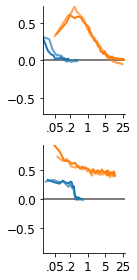

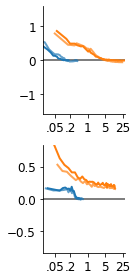

In [9]:
for k in range(2):
    fig, axs = plt.subplots(num_Ns, 1, figsize=(figlen/2.,figlen))
    for i, N in enumerate(Ns):
        ax = axs[i]
        ax.plot([np.log(min_time), np.log(max_time)], [0,0], '-k', alpha=0.5)
        max_val = None
        for j, g in enumerate(gs):
            # plot EPI
            optim = EPI_max_ent[(N,g)]
            epi_t = get_epi_times(optim)
            epi_R = optim['R%d' % (k+3)]
            ax.plot(np.log(epi_t/60.), epi_R, c=colors[0], alpha=alphas[j])

            # plot SNPE
            optim = SNPE_max_val[(N, g)]
            best_round = np.argmax(optim['round_val_log_probs'])
            xs = optim['xs'][:best_round]
            epoch_times, round_times = get_snpe_times(optim)
            snpe_t = round_times[:best_round]
            snpe_var = np.mean((xs-x0[None,None,:])**2, axis=1)
            snpe_R = snpe_var[:,k] - mu[k+2]
            ax.plot(np.log(snpe_t/60.), snpe_R, c=colors[1], alpha=alphas[j])
            max_val_j = max(np.max(np.abs(snpe_R[1:])), np.max(np.abs(epi_R)))
            if max_val is None or max_val < max_val_j:
                max_val = max_val_j
        ax.set_xlim([np.log(min_time), np.log(max_time)])
        ax.set_ylim([-max_val, max_val])
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
    plt.tight_layout()
    plt.savefig(os.path.join("figures", "figRNN1", "RNN1_mu%d_vars.pdf" % (k+1)))